In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# eager execution
tf.enable_eager_execution()
tf.executing_eagerly()

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('./COCO2017/', 'train',
                                 num_max_gts=1000,
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1024))

loading annotations into memory...
Done (t=11.38s)
creating index...
index created!


#### display a sample

In [5]:
img, img_meta, bbox, label = train_dataset[0]
rgb_img = np.round(img + img_mean)

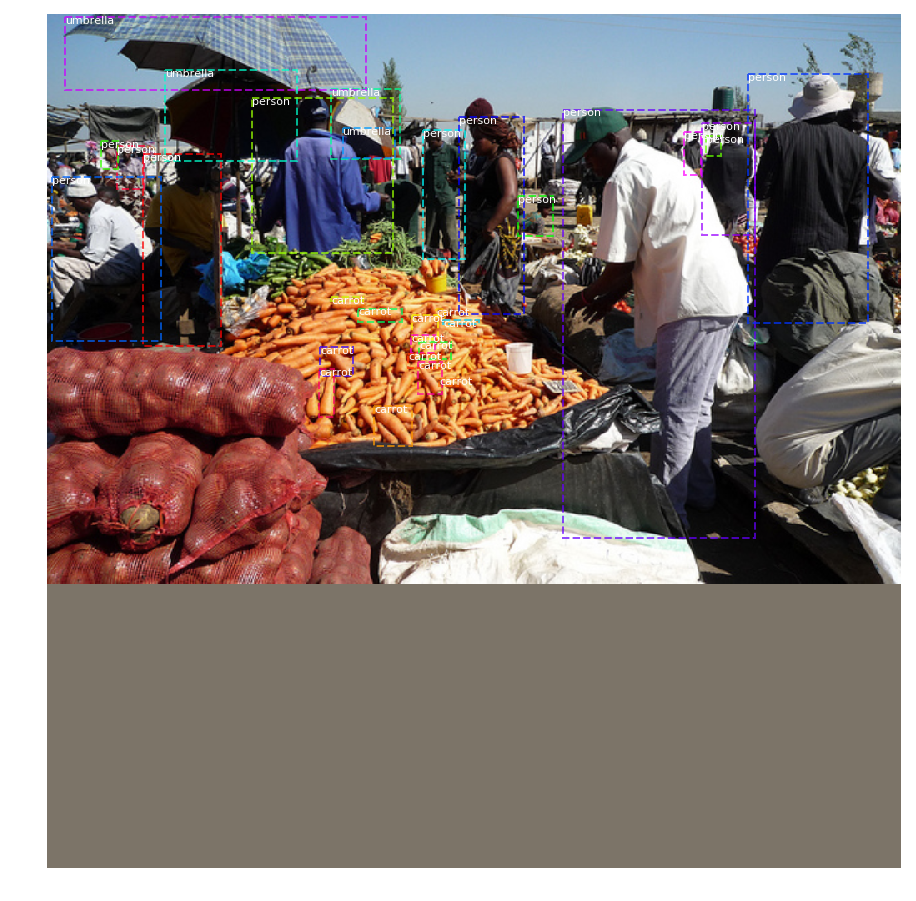

In [6]:
visualize.display_instances(rgb_img, bbox, label, train_dataset.get_categories())

#### load model

In [7]:
from detection.models.detectors import faster_rcnn

In [8]:
imgs = tf.Variable(np.expand_dims(img, 0))
img_metas = tf.Variable(np.expand_dims(img_meta, 0))
bboxes = tf.Variable(np.expand_dims(bbox, 0))
labels = tf.Variable(np.expand_dims(label, 0))

In [9]:
model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

_ = model((imgs, img_metas, bboxes, labels), training=True)

In [10]:
model.load_weights('weights/faster_rcnn.h5')

### Stage 1: Region Proposal Network

#### 1.a RPN Targets

In [11]:
from detection.core.anchor import anchor_generator, anchor_target

In [12]:
generator = anchor_generator.AnchorGenerator(
    scales=(32, 64, 128, 256, 512), 
    ratios=(0.5, 1, 2), 
    feature_strides=(4, 8, 16, 32, 64))

anchor_target = anchor_target.AnchorTarget(
    target_means=(0., 0., 0., 0.), 
    target_stds=(0.1, 0.1, 0.2, 0.2))

In [13]:
anchors, valid_flags = generator.generate_pyramid_anchors(img_metas)

rpn_target_matchs, rpn_target_deltas = anchor_target.build_targets(
                anchors, valid_flags, bboxes, labels)

In [14]:
positive_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, 1))[:, 1])
negative_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, -1))[:, 1])
neutral_anchors = tf.gather(anchors, tf.where(tf.equal(rpn_target_matchs, 0))[:, 1])
positive_target_deltas = rpn_target_deltas[0, :tf.where(tf.equal(rpn_target_matchs, 1)).shape[0]]

In [15]:
from detection.core.bbox import transforms
    
refined_anchors = transforms.delta2bbox(
    positive_anchors, positive_target_deltas, (0., 0., 0., 0.), (0.1, 0.1, 0.2, 0.2))

In [16]:
print('rpn_target_matchs:\t', rpn_target_matchs[0].shape.as_list())
print('rpn_target_deltas:\t', rpn_target_deltas[0].shape.as_list())
print('positive_anchors:\t', positive_anchors.shape.as_list())
print('negative_anchors:\t', negative_anchors.shape.as_list())
print('neutral_anchors:\t', neutral_anchors.shape.as_list())
print('refined_anchors:\t', refined_anchors.shape.as_list())

rpn_target_matchs:	 [261888]
rpn_target_deltas:	 [256, 4]
positive_anchors:	 [49, 4]
negative_anchors:	 [207, 4]
neutral_anchors:	 [261632, 4]
refined_anchors:	 [49, 4]


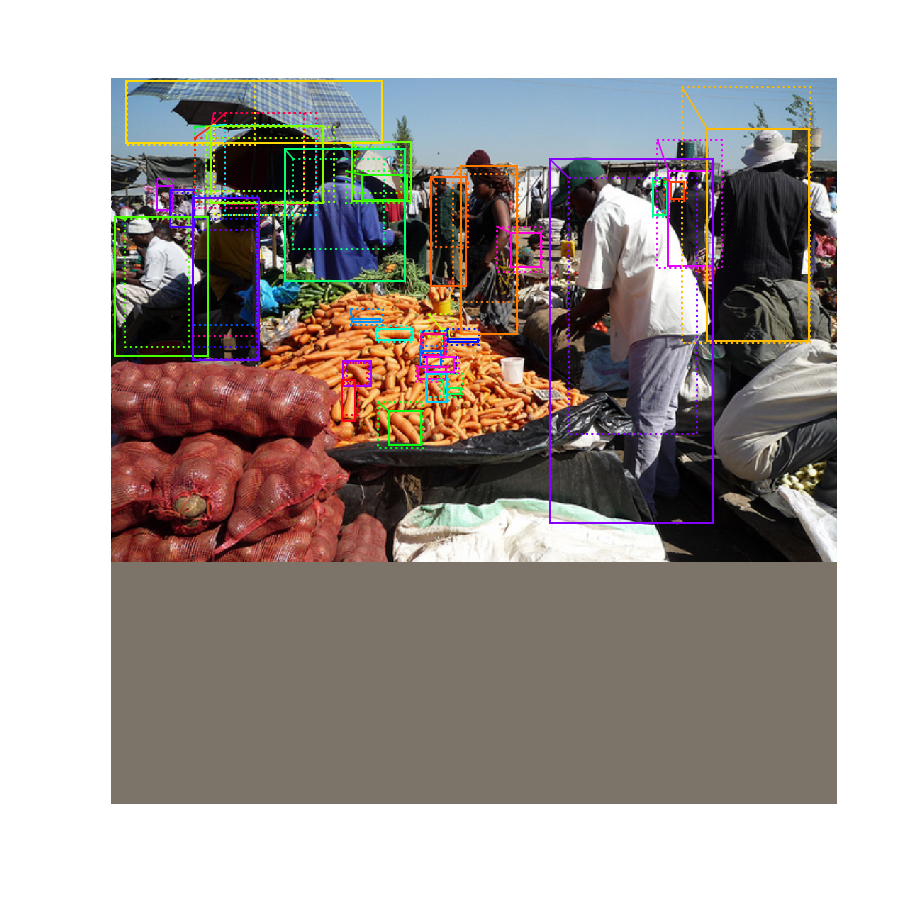

In [17]:
visualize.draw_boxes(rgb_img, 
                     boxes=positive_anchors.numpy(), 
                     refined_boxes=refined_anchors.numpy())

#### 1.b RPN Predictions

In [18]:
training = False
C2, C3, C4, C5 = model.backbone(imgs, 
                               training=training)

P2, P3, P4, P5, P6 = model.neck([C2, C3, C4, C5], 
                               training=training)

rpn_feature_maps = [P2, P3, P4, P5, P6]
rcnn_feature_maps = [P2, P3, P4, P5]

layer_outputs = []
for p in rpn_feature_maps:
    layer_outputs.append(model.rpn_head(p, training=training))

outputs = list(zip(*layer_outputs))
outputs = [tf.concat(list(o), axis=1) for o in outputs]

rpn_class_logits, rpn_probs, rpn_deltas = outputs

In [19]:
rpn_probs_tmp = rpn_probs[0, :, 1]

In [20]:
# Show top anchors by score (before refinement)
limit = 100
ix = tf.nn.top_k(rpn_probs_tmp, k=limit).indices[::-1]


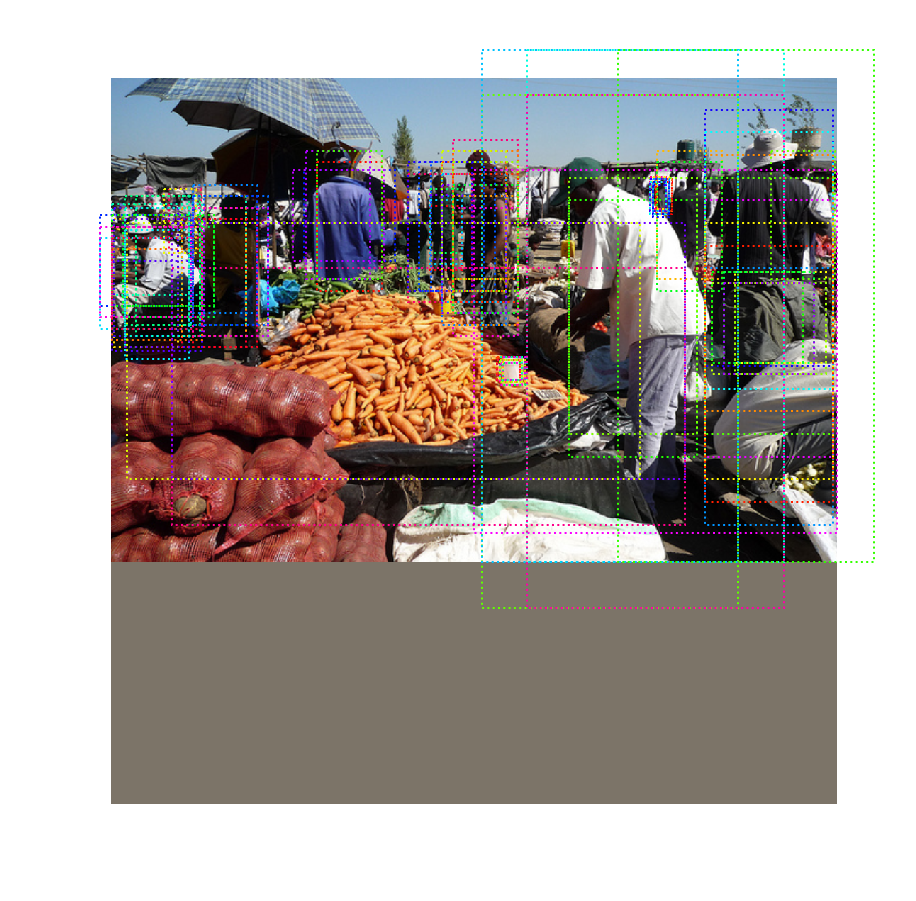

In [21]:
visualize.draw_boxes(rgb_img, boxes=tf.gather(anchors, ix).numpy())

### Stage 2:  Proposal Classification

In [22]:
proposals_list = model.rpn_head.get_proposals(
    rpn_probs, rpn_deltas, anchors, valid_flags, img_metas)

In [23]:
rois_list = proposals_list

pooled_regions_list = model.roi_align(
    (rois_list, rcnn_feature_maps, img_metas), training=training)

rcnn_class_logits_list, rcnn_probs_list, rcnn_deltas_list = \
    model.bbox_head(pooled_regions_list, training=training)


In [24]:
detections_list = model.bbox_head.get_bboxes(
    rcnn_probs_list, rcnn_deltas_list, rois_list, img_metas)

In [25]:
tmp = detections_list[0][:, :4]

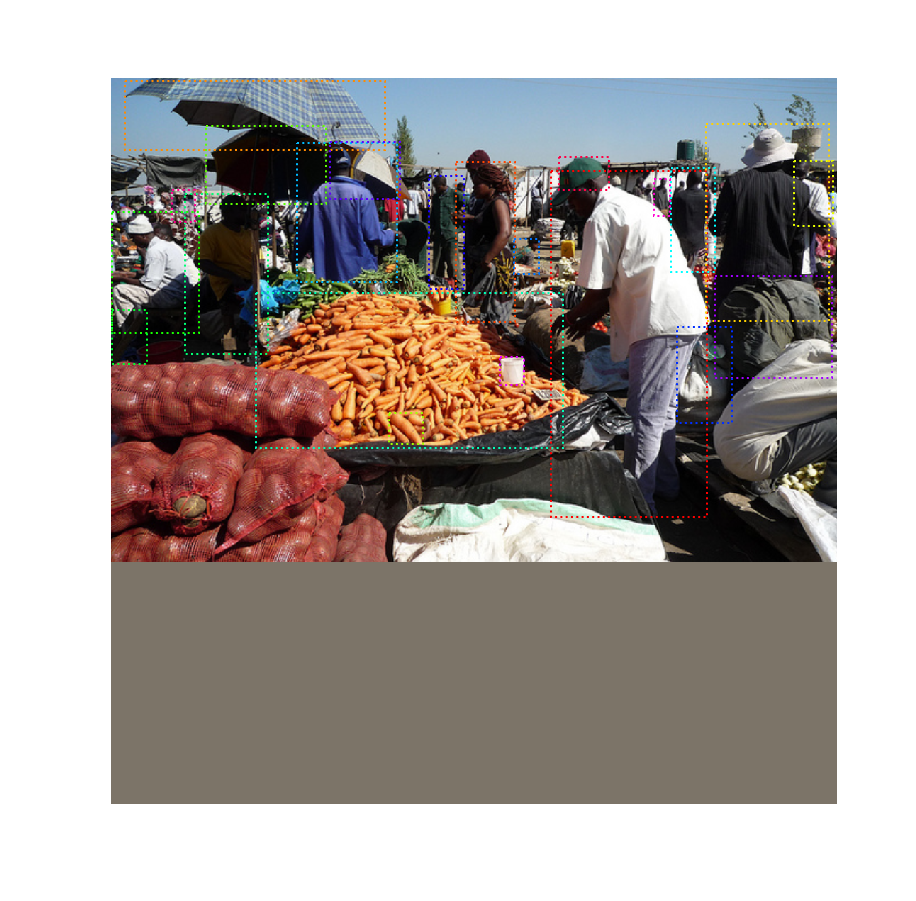

In [26]:
visualize.draw_boxes(rgb_img, boxes=tmp.numpy())

### Stage 3: Run model directly

In [27]:
res = model((imgs, img_metas), training=False)[0]

In [28]:
from detection.datasets.utils import generate_ori_img

In [29]:
ori_img = generate_ori_img(img, img_meta, img_mean)

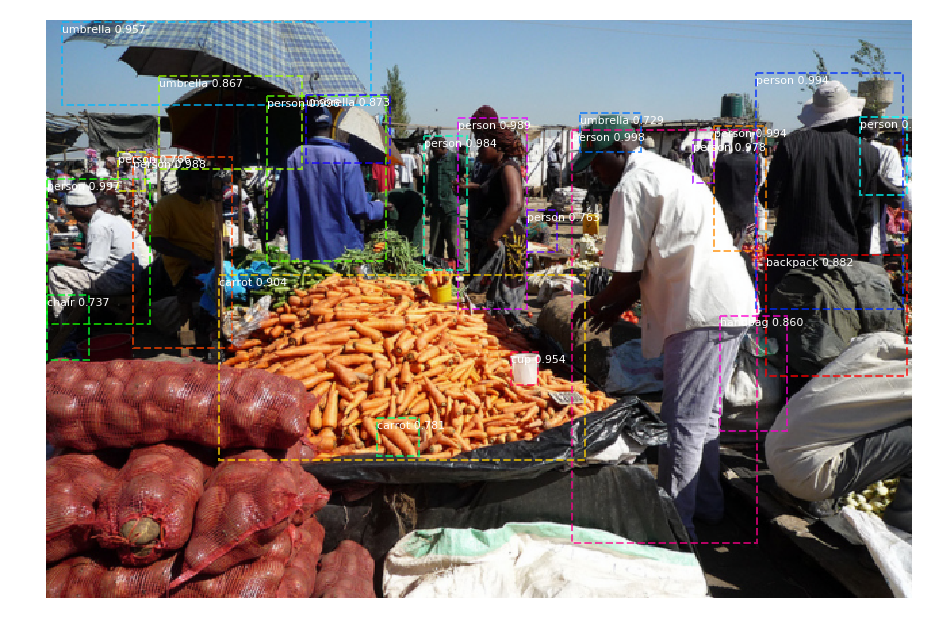

In [30]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])